In [7]:
import seaborn as sns
import sys
import pandas as pd

sys.path.append(r'..')
sys.path.append(r'.')
%load_ext autoreload
%autoreload 2

from process_data import process_mutation_data
from statistical_test import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# RQ1: How destructive are Zest's mutations in general? Are disruptive mutaions beneficial for fuzzing?

In [8]:
#process_mutation_data("/data/aoli/results-JQF/ei-m510-mutation/", [False, True], ["testWithGenerator"], ["zest"])
# load the df from pickle
mutation_df = pd.read_pickle('./mutation.pkl')

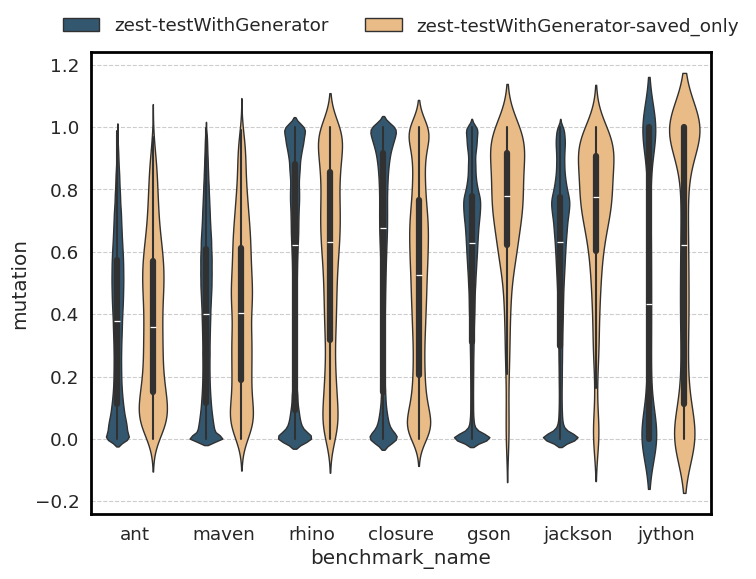

In [ ]:
# violin plot 
tmp_ax = sns.violinplot(data=mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

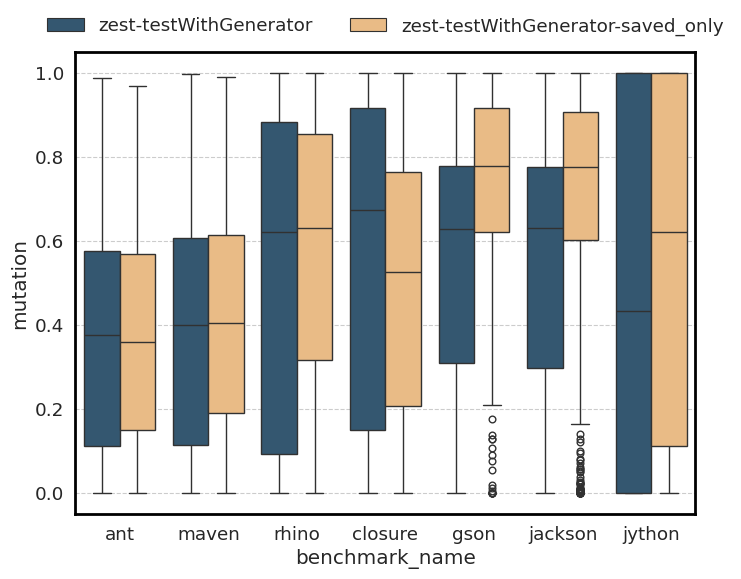

In [26]:
tmp_ax = sns.boxplot(data=mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

In [9]:
# stats table 
measures = ['count', '50%', 'mean', 'std', 'min', 'max']
mutation_groupby = mutation_df.groupby(['algorithm', 'benchmark_name'], as_index=False)
mutation_stats = mutation_groupby.describe()
processed_mutation_stats = mutation_stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
processed_mutation_stats

algorithm benchmark_name    mutation            \
                                                           count    median   
0              zest-testWithGenerator            ant   4414429.0  0.376712   
1              zest-testWithGenerator        closure   4227343.0  0.674625   
2              zest-testWithGenerator           gson   8066208.0  0.629310   
3              zest-testWithGenerator        jackson   7867518.0  0.631111   
4              zest-testWithGenerator         jython      3629.0  0.432432   
5              zest-testWithGenerator          maven  16429712.0  0.400000   
6              zest-testWithGenerator          rhino   7466363.0  0.622146   
7   zest-testWithGenerator-saved_only            ant      2461.0  0.359756   
8   zest-testWithGenerator-saved_only        closure     21372.0  0.526709   
9   zest-testWithGenerator-saved_only           gson       402.0  0.777778   
10  zest-testWithGenerator-saved_only        jackson       769.0  0.774916   
11  zest-testWithGenerator-saved_only         jython      2417.0  0.621622   
12  zest-testWithGenerator-saved_only          maven      3598.0  0.404703   
13  zest-testWithGenerator-saved_only          rhino      6330.0  0.630029   

                                       
        mean       std  min       max  
0   0.367846  0.259308  0.0  0.987151  
1   0.567700  0.369213  0.0  1.000000  
2   0.542710  0.315610  0.0  0.999676  
3   0.538080  0.312901  0.0  0.999668  
4   0.472437  0.412604  0.0  1.000000  
5   0.387120  0.275879  0.0  0.996414  
6   0.525839  0.372346  0.0  1.000000  
7   0.378090  0.249160  0.0  0.968719  
8   0.504192  0.317645  0.0  1.000000  
9   0.733353  0.229722  0.0  0.999286  
10  0.708036  0.255379  0.0  0.999623  
11  0.562765  0.411060  0.0  1.000000  
12  0.412806  0.260993  0.0  0.990939  
13  0.574791  0.311742  0.0  1.000000

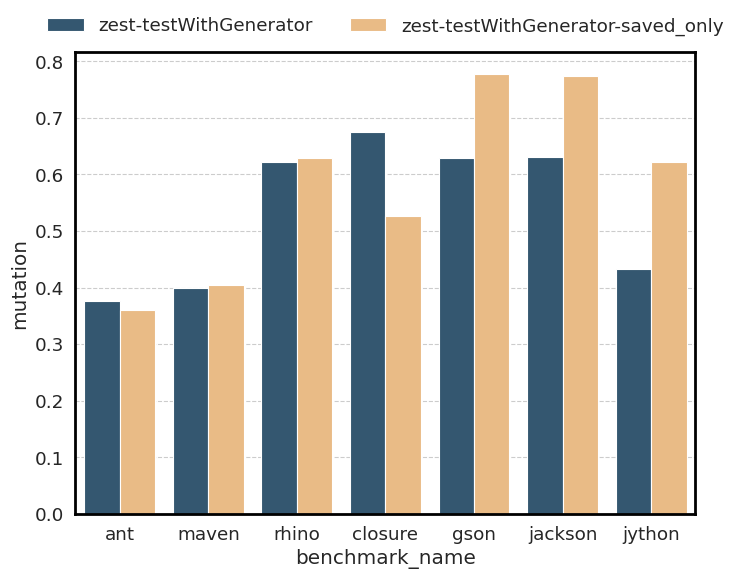

In [49]:
# get the median values
median_mutation_df = processed_mutation_stats.loc[:, (slice(None), ['', 'median'])]
# flatten the index
median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
# reorder the index 
median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
# bar plot
tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

In [ ]:
# statistical tests
result_dict = {}
test_names = ['two-sided', 'less']
measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
indices = []
for name in test_names:
    indices += ['{}_{}'.format(name, measure) for measure in measures]

In [ ]:
# TODO: large, unequal sample sizes; debugging required
for benchmark_name in mutation_df.benchmark_name.unique():
    print('testing {}...'.format(benchmark_name))
    alg1_data = mutation_groupby.get_group(('zest-testWithGenerator', benchmark_name)).mutation.values
    alg2_data = mutation_groupby.get_group(('zest-testWithGenerator-saved_only', benchmark_name)).mutation.values
    print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
    result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
    result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
    result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
# create the dataframe
stats_df = pd.DataFrame(result_dict, index=indices) 
stats_df

testing ant...
[0.         0.5027933  0.46368715 ... 0.72833724 0.04215457 0.66978923]
[0.         0.5027933  0.46368715 ... 0.70143885 0.04391892 0.01131542]
sample1 size: 4414429, sample2 size: 2461


: 